In [1]:
# vgg16 transfer learning final version
import matplotlib.pyplot as plt
import time
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

In [2]:
#Verificamos que tensorflow está usando el gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10016282323802374622
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5723127808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16062485461504122141
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
]


In [3]:
# define cnn model
def define_model():
    # load model
    model = VGG19(include_top=False, input_shape= (224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable= False #Con esto le digo al modelo que no entrene las capas del modelo precargado

    model.get_layer('block4_conv1').trainable = True
    model.get_layer('block4_conv2').trainable = True
    model.get_layer('block4_conv3').trainable = True
    model.get_layer('block4_pool').trainable = True

    model.get_layer('block5_conv1').trainable = True
    model.get_layer('block5_conv2').trainable = True
    model.get_layer('block5_conv3').trainable = True
    model.get_layer('block5_pool').trainable = True
    
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output) # Realiza el aplanado de todo el modelo menos de la ultima capa
    class1 = Dense(units=1024, activation='relu', kernel_initializer='he_uniform', kernel_regularizer="l2")(flat1)
    x = Dropout(0.4)(class1)

    # # Adding an addtional dense layer
    # class2 = Dense(units=256, activation="relu", kernel_initializer='he_uniform')(x)
    # x = Dropout(0.30)(class2)

    output = Dense(units=1, activation='sigmoid')(x)
    #define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(learning_rate=0.0000001, momentum=0.7)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    #plot graph
    #MLP=plot_model(model, to_file='4.svg');
    return model

In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.title('Binary cross entropy loss')
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'k--', label='Training loss')
    plt.plot(epochs, val_loss, 'g--', label='Validation loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig('vgg16_loss_final_version.pdf')
    plt.show()
    # plot accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(loss))
    plt.plot(epochs, accuracy, 'k--', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g--', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig('vgg16_accu_final_version.pdf')
    plt.show()
    print("> The loss function value in the validation state is %.4f" % (val_loss[-1]))
    print("> The accuracy value in the validation state is %.4f" % (val_loss[-1]))

In [5]:
# run the test harness for evaluating a model
def run_test_harness():
    # Record the start time
    start_time = time.time()

    # define model
    model = define_model()
    # create data generator
    train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(featurewise_center=True)
    valid_datagen = ImageDataGenerator(featurewise_center=True)
      # specify imagenet mean values for centering
    train_datagen.mean = [123.68, 116.779, 103.939]
    valid_datagen.mean = [123.68, 116.779, 103.939]
    test_datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterators
    train_it = train_datagen.flow_from_directory('Civil-damage-2_classes/train/',
class_mode='binary', batch_size=2, target_size=(224, 224))
    valid_it = valid_datagen.flow_from_directory('Civil-damage-2_classes/valid/',
class_mode='binary', batch_size=2, target_size=(224, 224))
    test_it = test_datagen.flow_from_directory('Civil-damage-2_classes/test/',
class_mode='binary', batch_size=2, target_size=(224, 224))
    checkpointer = ModelCheckpoint(filepath="model_final_version.weights.best.hdf5", verbose=1, save_best_only=True)
    
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
validation_data=valid_it, validation_steps=len(valid_it), epochs=250, verbose=1, callbacks=[checkpointer])
    
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print("> The model's accuracy in the testing estate is %.4f" % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)

    # Record the end time
    end_time = time.time()

    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    print(f"The total time was: {elapsed_time} seconds")

    # Saving the model
    model.save('final_model.h5')
    model.save_weights('final_model_weights.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

c:\Users\TORIT\anaconda3\envs\Tensor_GPU_4060_Keras\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


32/32 [==============================] - 1s 22ms/step - loss: 20.7354 - accuracy: 0.9844
> The model's accuracy in the testing estate is 98.4375


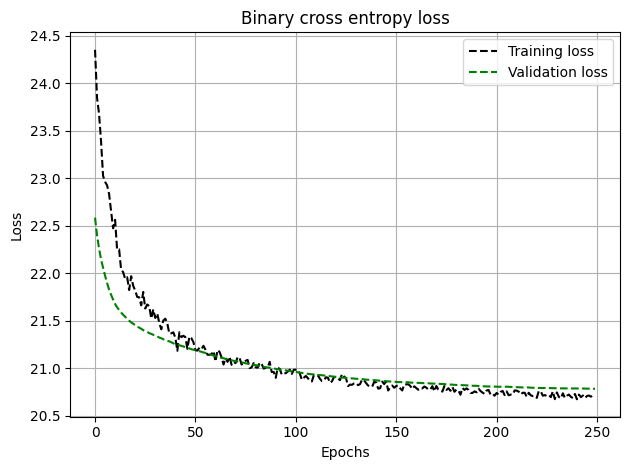

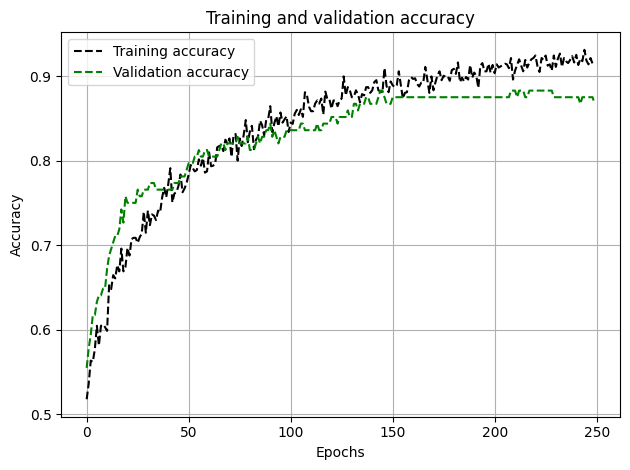

> The loss function value in the validation state is 20.7833
> The accuracy value in the validation state is 20.7833
The total time was: 7069.36421585083 seconds


In [6]:
# entry point, run the test harness
run_test_harness()

In [7]:
flat1 = Flatten()(model.layers[-1].output) # Realiza el aplanado de todo el modelo menos de la ultima capa
    class1 = Dense(units=512, activation='relu', kernel_initializer='he_uniform')(flat1)
    x = Dropout(0.45)(class1)
opt = SGD(learning_rate=0.000001, momentum=0.75)
batch_size=4,
> The loss function value in the validation state is 0.2199
> The accuracy value in the validation state is 0.2199
The total time was: 3225.6782138347626 seconds

IndentationError: unexpected indent (4283337011.py, line 2)

In [ ]:
flat1 = Flatten()(model.layers[-1].output) # Realiza el aplanado de todo el modelo menos de la ultima capa
    class1 = Dense(units=512, activation='relu', kernel_initializer='he_uniform')(flat1)
    x = Dropout(0.45)(class1)
opt = SGD(learning_rate=0.000001, momentum=0.8)
batch_size=4,
> The loss function value in the validation state is 0.2199
> The accuracy value in the validation state is 0.2199
The total time was: 3225.6782138347626 seconds
16/16 [==============================] - 1s 59ms/step - loss: 0.1432 - accuracy: 0.9844
24s 73ms/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.2511 - val_accuracy: 0.9375
> The model's accuracy in the testing estate is 98.4375
> The loss function value in the validation state is 0.2511
> The accuracy value in the validation state is 0.2511
The total time was: 6469.304037094116 seconds

In [ ]:
flat1 = Flatten()(model.layers[-1].output) # Realiza el aplanado de todo el modelo menos de la ultima capa
    class1 = Dense(units=512, activation='relu', kernel_initializer='he_uniform')(flat1)
    x = Dropout(0.4)(class1)
opt = SGD(learning_rate=0.00001, momentum=0.7)
batch_size=4,
> The loss function value in the validation state is 0.2199
> The accuracy value in the validation state is 0.2199
The total time was: 3225.6782138347626 seconds
16/16 [==============================] - 1s 59ms/step - loss: 0.1432 - accuracy: 0.9844

> The model's accuracy in the testing estate is 98.4375
> The loss function value in the validation state is 0.2511
> The accuracy value in the validation state is 0.2511
The total time was: 6469.304037094116 seconds